### 1. Importing the Libraries, and Inspecting the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/hospital_readmission_clean.csv")
print(df.shape)
df.head()

(8121, 12)


,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,07/01/2020,06/30/2023
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,07/01/2020,06/30/2023
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,07/01/2020,06/30/2023
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,07/01/2020,06/30/2023
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-COPD-HRRP,130.0,NaN,0.9330,15.4544,16.5637,16,07/01/2020,06/30/2023


In [4]:
df.info()
df.describe(include='all')
df['State'].nunique(), df['Measure Name'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Facility Name               8121 non-null   object 
 1   Facility ID                 8121 non-null   int64  
 2   State                       8121 non-null   object 
 3   Measure Name                8121 non-null   object 
 4   Number of Discharges        8121 non-null   float64
 5   Footnote                    0 non-null      float64
 6   Excess Readmission Ratio    8121 non-null   float64
 7   Predicted Readmission Rate  8121 non-null   float64
 8   Expected Readmission Rate   8121 non-null   float64
 9   Number of Readmissions      8121 non-null   int64  
 10  Start Date                  8121 non-null   object 
 11  End Date                    8121 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 761.5+ KB


(51, 6)

In [8]:
# Keeping only the relevant columns for analysis.

cols_to_keep = [
    'Facility Name',
    'Facility ID',
    'State',
    'Measure Name',
    'Number of Discharges',
    'Number of Readmissions',
    'Predicted Readmission Rate',
    'Expected Readmission Rate',
    'Excess Readmission Ratio'
]

df = df[cols_to_keep].copy()

### 2. Distribution of Excess Readmission Ratios Across Hospitals

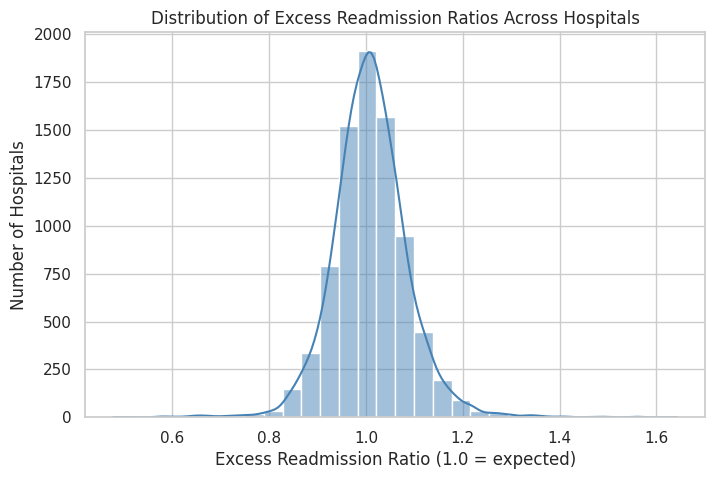

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df['Excess Readmission Ratio'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Excess Readmission Ratios Across Hospitals')
plt.xlabel('Excess Readmission Ratio (1.0 = expected)')
plt.ylabel('Number of Hospitals')
plt.show()

### 3. Predicted vs Expected Readmission Rates

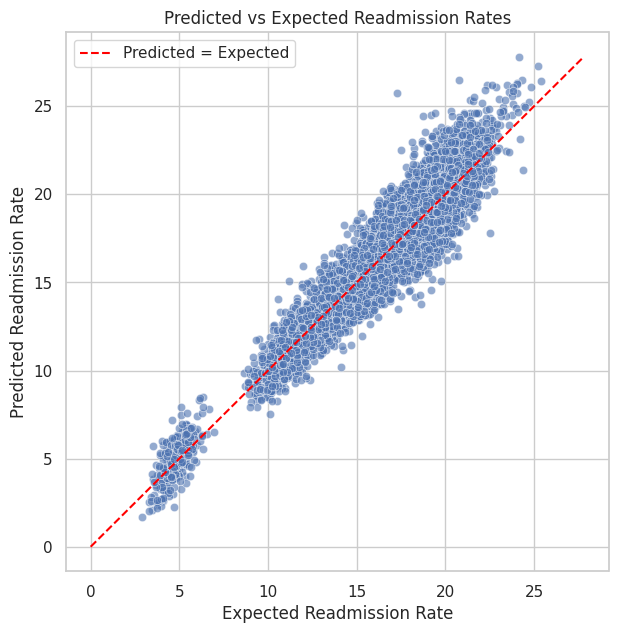

In [12]:
plt.figure(figsize=(7,7))
sns.scatterplot(
    x='Expected Readmission Rate',
    y='Predicted Readmission Rate',
    data=df,
    alpha=0.6
)
max_val = max(df['Expected Readmission Rate'].max(), df['Predicted Readmission Rate'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Predicted = Expected')
plt.title('Predicted vs Expected Readmission Rates')
plt.legend()
plt.show()

### 4. Variation by Condition

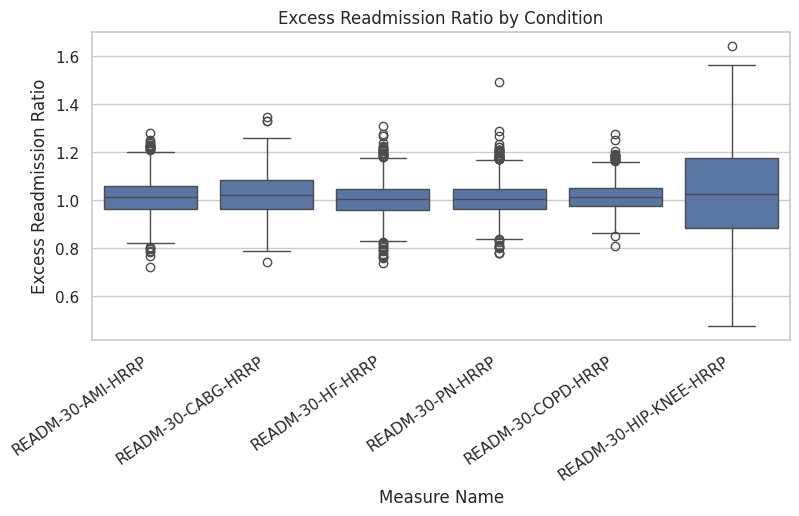

In [14]:
plt.figure(figsize=(9,4))
sns.boxplot(data=df, x='Measure Name', y='Excess Readmission Ratio')
plt.xticks(rotation=35, ha='right')
plt.title('Excess Readmission Ratio by Condition')
plt.show()

### 5. 